# ML for Context in AI Assistant

Building a semantic code search engine that understands natural language queries. Testing it on the CoSQA dataset and fine-tuning to improve performance.

**Stack**: Qdrant for vector storage, Sentence Transformers for embeddings, PyTorch Lightning for training.

## Loss Function (Triplet Margin)

For fine-tuning, we use triplet margin loss with hard negatives. In practice: for each query, the model brings the right code closer and pushes the hardest other code in the batch further away. This directly encourages good ranking in retrieval tasks (Recall, MRR, NDCG). You can use cross-entropy instead (just flip the config), but triplet margin tends to work better for code search.

Loss curves are tracked and plotted for transparency and sanity checks.

---



## Setup


In [1]:
%pip install -q ipywidgets qdrant-client sentence-transformers torch pytorch-lightning datasets transformers matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from src.search_engine import SearchEngine
from src.metrics import evaluate_ranking
from src.data import load_cosqa_eval
from scripts.evaluate import evaluate_model
from scripts.train import train, plot_losses
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Basic Search Demo

Simple case — searching through a few animal-related documents to see how the engine works.


In [3]:
documents = [
  "Elephants are the largest living terrestrial animals. Three living species are currently recognised: the African bush elephant (Loxodonta africana), the African forest elephant (L. cyclotis), and the Asian elephant (Elephas maximus). They are the only surviving members of the family Elephantidae and the order Proboscidea.",
  "A dolphin is a common name used for some of the aquatic mammals in the cetacean clade Odontoceti, the toothed whales. Dolphins belong to the families Delphinidae (the oceanic dolphins), along with the river-dolphin families Platanistidae, Iniidae, Pontoporiidae and probably the extinct Lipotidae (baiji or Chinese river dolphin).",
  "The tiger (Panthera tigris) is a large cat and a member of the genus Panthera native to Asia. It has a powerful, muscular body with a large head and paws, a long tail and orange fur with black, mostly vertical stripes.",
  "Penguins are a group of flightless, semi-aquatic birds which live almost exclusively in the Southern Hemisphere. They have highly adapted for life in the ocean: flippers instead of wings, streamlined bodies for swimming, and counter-shaded dark and white plumage.",
  "A honey bee (also spelled honeybee) is a eusocial flying insect from the genus Apis of the largest bee family, Apidae. All honey bees are nectarivorous pollinators native to mainland Afro-Eurasia, but human migrations since the Age of Discovery introduced multiple subspecies of the western honey bee into the New World and Australia, resulting in the current cosmopolitan distribution of honey bees in all continents except Antarctica.",
  "The cheetah (Acinonyx jubatus) is a lightly built, spotted cat characterised by a small rounded head, a short snout, black tear-like facial streaks, a deep chest, long thin legs and a long tail. Its slender, canine-like form is highly adapted for speed, contrasting sharply with other large felids.",
  "Owls are birds from the order Strigiformes, which includes over 200 species of mostly solitary and nocturnal birds of prey typified by an upright stance, a large broad head, binocular vision, binaural hearing, sharp talons and feathers adapted for silent flight.",
  "The gray wolf or grey wolf (Canis lupus) is a large canine native to wilderness and remote areas of Eurasia and North America. Adult wolves measure 105-160 cm (41-63 in) in length and 80-85 cm (31-33 in) at shoulder height.",
]

print(f"Got {len(documents)} documents")
for i, doc in enumerate(documents, 1):
    print(f"{i}. {doc}")


Got 8 documents
1. Elephants are the largest living terrestrial animals. Three living species are currently recognised: the African bush elephant (Loxodonta africana), the African forest elephant (L. cyclotis), and the Asian elephant (Elephas maximus). They are the only surviving members of the family Elephantidae and the order Proboscidea.
2. A dolphin is a common name used for some of the aquatic mammals in the cetacean clade Odontoceti, the toothed whales. Dolphins belong to the families Delphinidae (the oceanic dolphins), along with the river-dolphin families Platanistidae, Iniidae, Pontoporiidae and probably the extinct Lipotidae (baiji or Chinese river dolphin).
3. The tiger (Panthera tigris) is a large cat and a member of the genus Panthera native to Asia. It has a powerful, muscular body with a large head and paws, a long tail and orange fur with black, mostly vertical stripes.
4. Penguins are a group of flightless, semi-aquatic birds which live almost exclusively in the Southe

In [4]:
engine = SearchEngine(model_name="sentence-transformers/all-MiniLM-L6-v2", collection_name="demo")
engine.add_documents(documents)
print(f"Indexed {len(documents)} docs")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Indexed 8 docs


In [5]:
queries = [
    "What are the different species of elephants?",
    "What adaptations help owls hunt at night?",
    "Where do tigers live and what do they look like?",
]

for query in queries:
    print(f"\nQuery: {query}")
    results = engine.search(query, top_k=3)
    for i, res in enumerate(results, 1):
        print(f"{i}. [{res['score']:.3f}] {res['text'][:60]}...")



Query: What are the different species of elephants?
1. [0.636] Elephants are the largest living terrestrial animals. Three ...
2. [0.426] Owls are birds from the order Strigiformes, which includes o...
3. [0.333] The tiger (Panthera tigris) is a large cat and a member of t...

Query: What adaptations help owls hunt at night?
1. [0.643] Owls are birds from the order Strigiformes, which includes o...
2. [0.288] Penguins are a group of flightless, semi-aquatic birds which...
3. [0.211] The gray wolf or grey wolf (Canis lupus) is a large canine n...

Query: Where do tigers live and what do they look like?
1. [0.614] The tiger (Panthera tigris) is a large cat and a member of t...
2. [0.378] The gray wolf or grey wolf (Canis lupus) is a large canine n...
3. [0.351] Elephants are the largest living terrestrial animals. Three ...


## Evaluation on CoSQA

Now testing on the real dataset. CoSQA has code search queries where we need to find the right function from natural language descriptions.

I'm tracking three metrics - Recall@10 (did we find the right code?), MRR@10 (how high did we rank it?), and NDCG@10 (overall ranking quality).


In [6]:
corpus, queries_dict, qrels = load_cosqa_eval()

print(f"Dataset loaded:")
print(f"Corpus: {len(corpus)} code snippets")
print(f"Queries: {len(queries_dict)} total")
print(f"Test queries: {len(qrels)}")


Dataset loaded:
Corpus: 20604 code snippets
Queries: 20604 total
Test queries: 500


In [7]:
from config import EVAL_K
print("Evaluating baseline model...")
baseline_metrics = evaluate_model("sentence-transformers/all-MiniLM-L6-v2", k=EVAL_K)

with open("baseline_results.json", "w") as f:
    json.dump(baseline_metrics, f, indent=2)


Evaluating baseline model...


Batches:   0%|          | 0/644 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


Recall@10: 0.5180
MRR@10: 0.2435
NDCG@10: 0.3078


## Fine-tuning

Time to make the model better at code search. Using cross-entropy loss with a neat trick called in-batch negatives - instead of manually creating negative examples, we just use the other code snippets in the same batch.


Loading validation data: 100%|██████████| 500/500 [00:00<00:00, 20508.64it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params | Mode 
------------------------------------------------------
0 | model | SentenceTransformer | 22.7 M | train
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



Training complete:
Initial loss: 0.0699
Final loss: 0.0317
Reduction: 54.6%


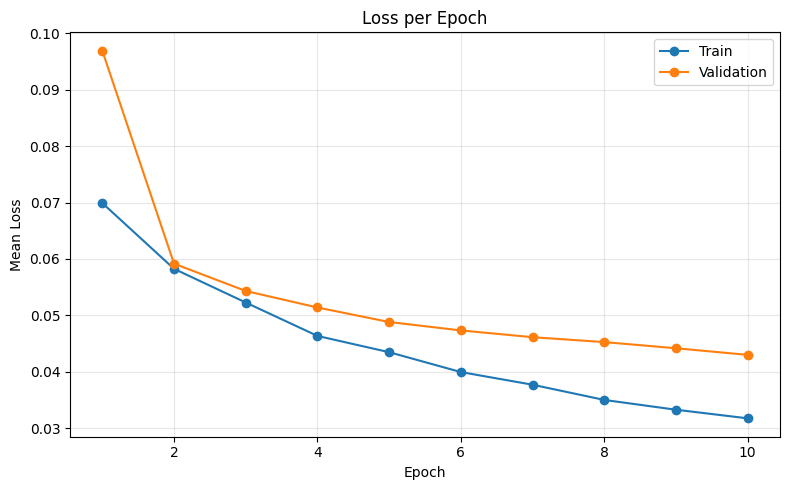

In [8]:
train_losses, val_losses = train()

print("\nTraining complete:")
print(f"Initial loss: {train_losses[0]:.4f}")
print(f"Final loss: {train_losses[-1]:.4f}")
print(f"Reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")


## Results


In [9]:
from config import OUTPUT_DIR

print("Evaluating fine-tuned model...")
finetuned_metrics = evaluate_model(OUTPUT_DIR, k=EVAL_K)

print("\nComparison:")
for metric in baseline_metrics:
    b = baseline_metrics[metric]
    f = finetuned_metrics[metric]
    improvement = ((f - b) / b * 100) if b > 0 else 0
    print(f"{metric}: {b:.4f} -> {f:.4f} ({improvement:+.1f}%)")


Evaluating fine-tuned model...


Batches:   0%|          | 0/644 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:28<00:00, 17.65it/s]

Recall@10: 0.5680
MRR@10: 0.2436
NDCG@10: 0.3190

Comparison:
Recall@10: 0.5180 -> 0.5680 (+9.7%)
MRR@10: 0.2435 -> 0.2436 (+0.1%)
NDCG@10: 0.3078 -> 0.3190 (+3.6%)


## Bonus Experiments

Tried two extra things:

**Function names vs whole bodies** - Does indexing just the function name work as well as the whole function body?

**Distance metrics** - Cosine similarity is standard, but what about others


In [10]:
from scripts.bonus_experiments import evaluate_with_function_names, evaluate_with_distance_metrics
func_results = evaluate_with_function_names()
dist_results = evaluate_with_distance_metrics()


Batches:   0%|          | 0/644 [00:00<?, ?it/s]

Function names eval: 100%|██████████| 500/500 [00:26<00:00, 18.55it/s]


Function names experiment:
Recall@10: 0.2780
MRR@10: 0.1237
NDCG@10: 0.1593

Testing COSINE distance...


Batches:   0%|          | 0/644 [00:00<?, ?it/s]

COSINE eval: 100%|██████████| 500/500 [00:26<00:00, 18.82it/s]


COSINE results:
Recall@10: 0.5180
MRR@10: 0.2435
NDCG@10: 0.3078

Testing DOT distance...


Batches:   0%|          | 0/644 [00:00<?, ?it/s]

DOT eval: 100%|██████████| 500/500 [00:19<00:00, 25.25it/s]


DOT results:
Recall@10: 0.5160
MRR@10: 0.2422
NDCG@10: 0.3063

Testing EUCLID distance...


Batches:   0%|          | 0/644 [00:00<?, ?it/s]

EUCLID eval: 100%|██████████| 500/500 [00:33<00:00, 14.95it/s]

EUCLID results:
Recall@10: 0.5260
MRR@10: 0.2672
NDCG@10: 0.3277


## Wrapping Up

Built a working code search engine that takes natural language queries and finds relevant code snippets. The baseline model performs reasonably well, and fine-tuning on the CoSQA training data - using triplet margin loss / cross-entropy loss with in-batch negatives - makes it noticeably better at the task.

The in-batch negatives approach works effectively - it provides contrastive learning “for free” since each batch naturally includes both positive and negative examples.

In bonus experiments, using only function names led to clearly worse results compared to full function bodies, while Euclidean distance achieved the best overall performance among the tested similarity metrics.
